# Advanced Data Pipeline Visualization

This notebook provides a deep dive into the CPC-SNN data generation pipeline. It visualizes:
1. **The Final Dataset**: Inspecting the HDF5 samples (`mag`, `cos`, `sin`) generated by `generate_training_set.py`.
2. **The Preprocessing Pipeline**: Step-by-step visualization of how raw GW data is transformed into the model input format.

**Steps Covered:**
1. Raw Strain Fetching
2. Bandpass Filtering & Resampling
3. PSD Estimation & Whitening
4. STFT Computation
5. Magnitude/Phase Decomposition
6. Multi-IFO Projection (for Injections)

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gwpy.timeseries import TimeSeries
from scipy.signal import welch, stft

# Import project modules
from src.data_handling.gw_utils import get_whitened_strain, project_waveform_to_ifo, generate_waveform
from src.data_handling.gw_data import compute_stft, tf_to_mag_phase_channels
from src.utils.paths import DATA_DIR

# Configuration
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (15, 6)
H5_PATH = DATA_DIR / "cpc_snn_train.h5"

/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/.venv/lib/python3.13/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/gracjanziemianski/Documents/CPC-SNN-GravitationalWavesDetection/.venv/lib/python3.13/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en

## 1. Inspecting the Generated HDF5 Data

Let's load the generated dataset and visualize a random sample (Signal vs Background).

=== Sample 000001 (SIGNAL) ===
Source Class: BBH
IFOs: H1,L1


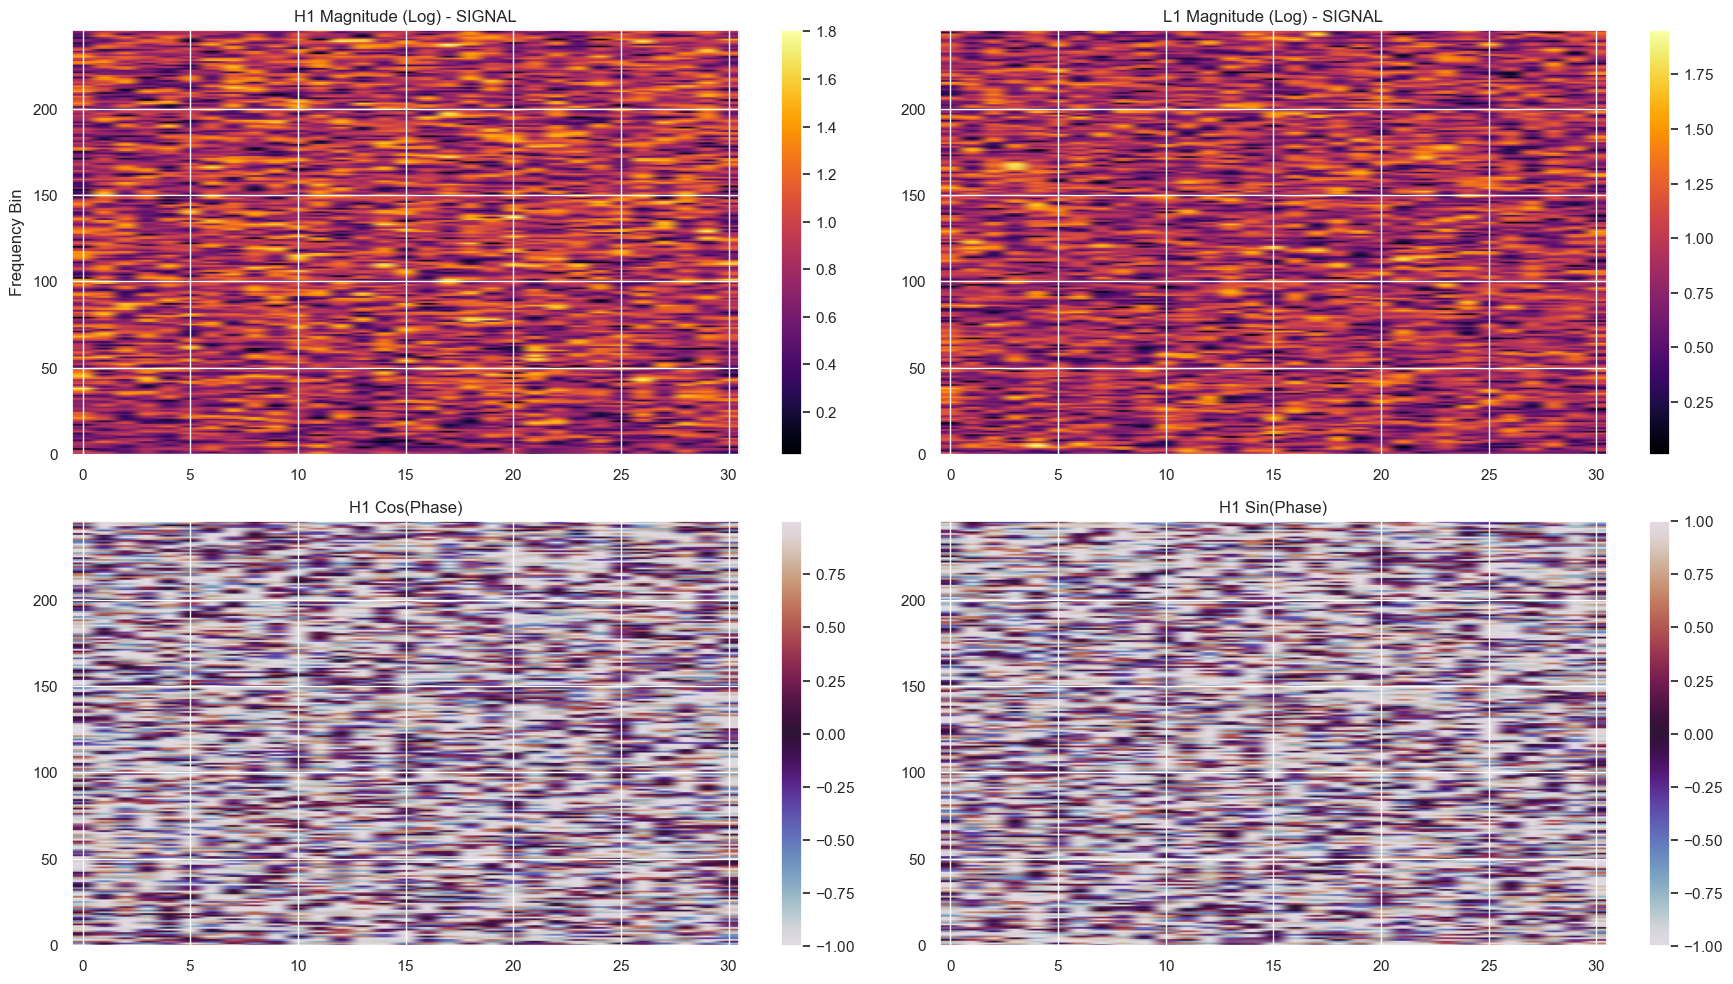

=== Sample 000000 (BACKGROUND) ===
Source Class: BACKGROUND
IFOs: H1,L1


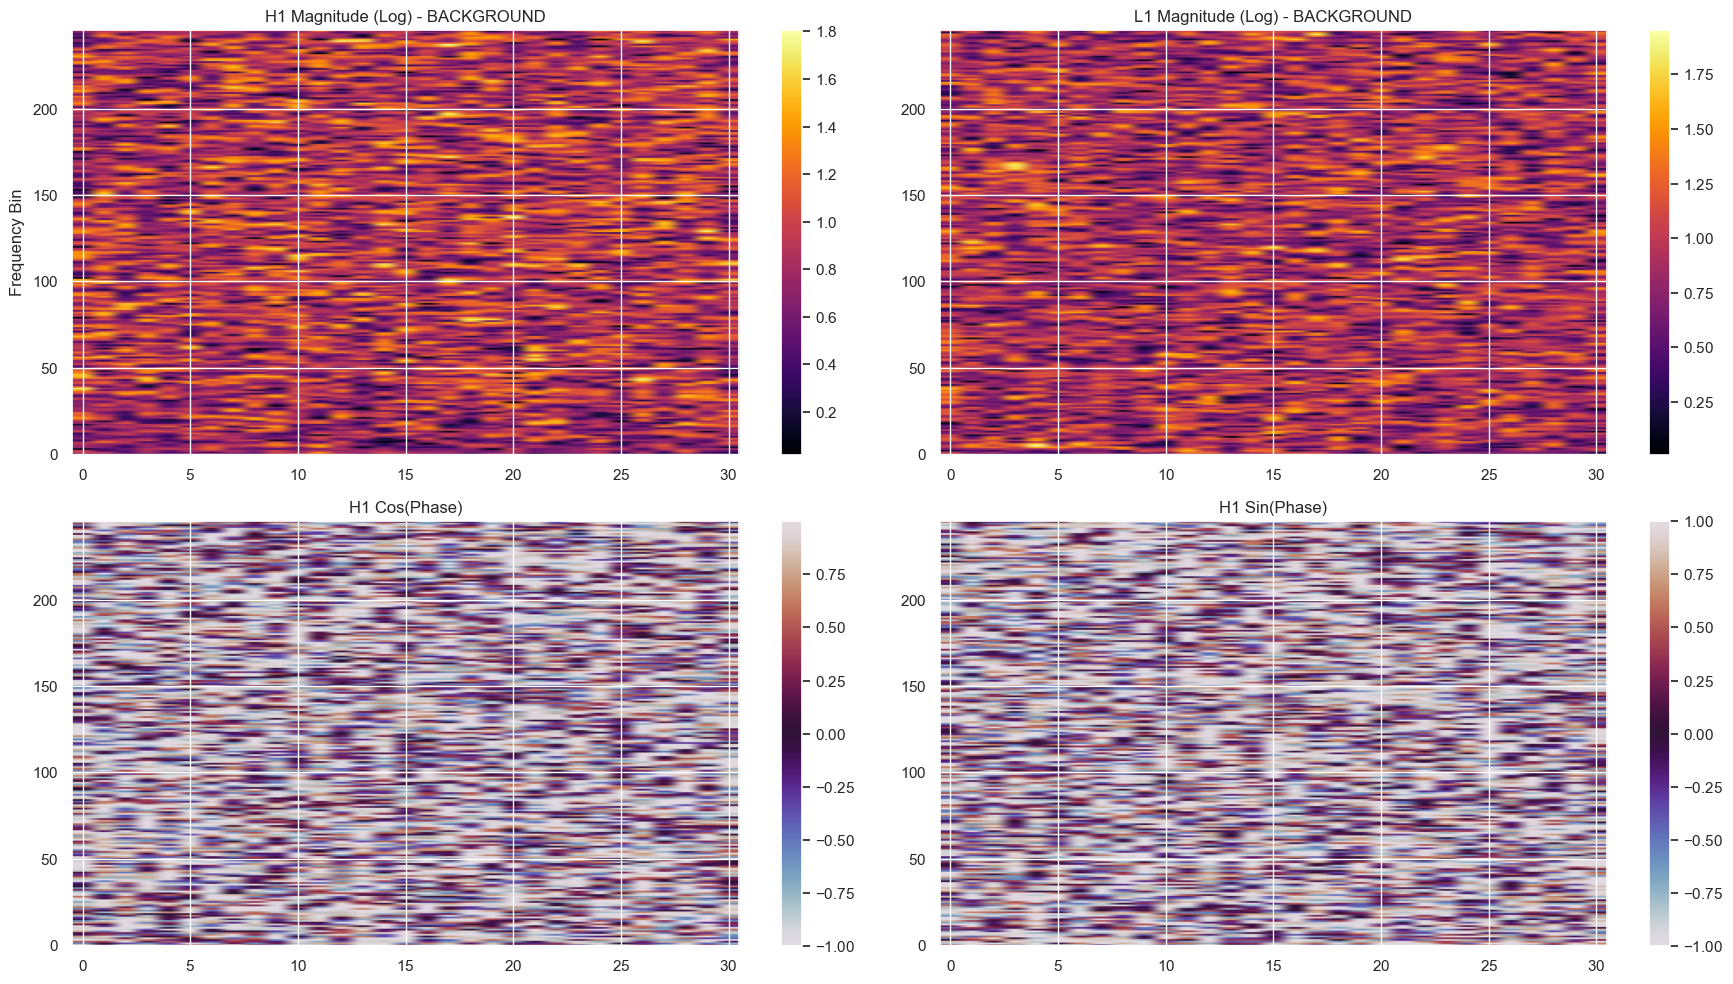

In [2]:
def plot_sample(h5_path, sample_id):
    with h5py.File(h5_path, 'r') as f:
        if sample_id not in f:
            print(f"Sample {sample_id} not found.")
            return
        
        grp = f[sample_id]
        meta = grp["meta"].attrs
        is_signal = meta["is_signal"]
        label_str = "SIGNAL" if is_signal else "BACKGROUND"
        
        print(f"=== Sample {sample_id} ({label_str}) ===")
        print(f"Source Class: {meta['source_class']}")
        print(f"IFOs: {meta['ifos']}")
        
        # Load Data
        H1_mag = grp["H1/mag"][()]
        H1_cos = grp["H1/cos"][()]
        H1_sin = grp["H1/sin"][()]
        
        L1_mag = grp["L1/mag"][()]
        
        freqs = grp["f"][()]
        
        # Plotting
        fig, axes = plt.subplots(2, 2, figsize=(18, 10))
        
        # H1 Magnitude
        im0 = axes[0,0].imshow(np.log1p(H1_mag.T), aspect='auto', origin='lower', cmap='inferno')
        axes[0,0].set_title(f"H1 Magnitude (Log) - {label_str}")
        axes[0,0].set_ylabel("Frequency Bin")
        plt.colorbar(im0, ax=axes[0,0])
        
        # L1 Magnitude
        im1 = axes[0,1].imshow(np.log1p(L1_mag.T), aspect='auto', origin='lower', cmap='inferno')
        axes[0,1].set_title(f"L1 Magnitude (Log) - {label_str}")
        plt.colorbar(im1, ax=axes[0,1])
        
        # H1 Phase (Cos)
        im2 = axes[1,0].imshow(H1_cos.T, aspect='auto', origin='lower', cmap='twilight')
        axes[1,0].set_title("H1 Cos(Phase)")
        plt.colorbar(im2, ax=axes[1,0])
        
        # H1 Phase (Sin)
        im3 = axes[1,1].imshow(H1_sin.T, aspect='auto', origin='lower', cmap='twilight')
        axes[1,1].set_title("H1 Sin(Phase)")
        plt.colorbar(im3, ax=axes[1,1])
        
        plt.tight_layout()
        plt.show()

# Find a signal and a background sample
with h5py.File(H5_PATH, 'r') as f:
    keys = list(f.keys())
    sig_key = next((k for k in keys if f[k]["meta"].attrs["is_signal"] == 1), None)
    bg_key = next((k for k in keys if f[k]["meta"].attrs["is_signal"] == 0), None)

if sig_key:
    plot_sample(H5_PATH, sig_key)
if bg_key:
    plot_sample(H5_PATH, bg_key)

## 2. The Preprocessing Pipeline: Step-by-Step

Now we will manually reproduce the pipeline on a live segment of data to visualize every transformation.

Fetching 32.0s of data from H1 starting at 1262304018...
Fetched 1 URLs from gwosc.org for [1262304018 .. 1262304050))
Reading data... [Done]


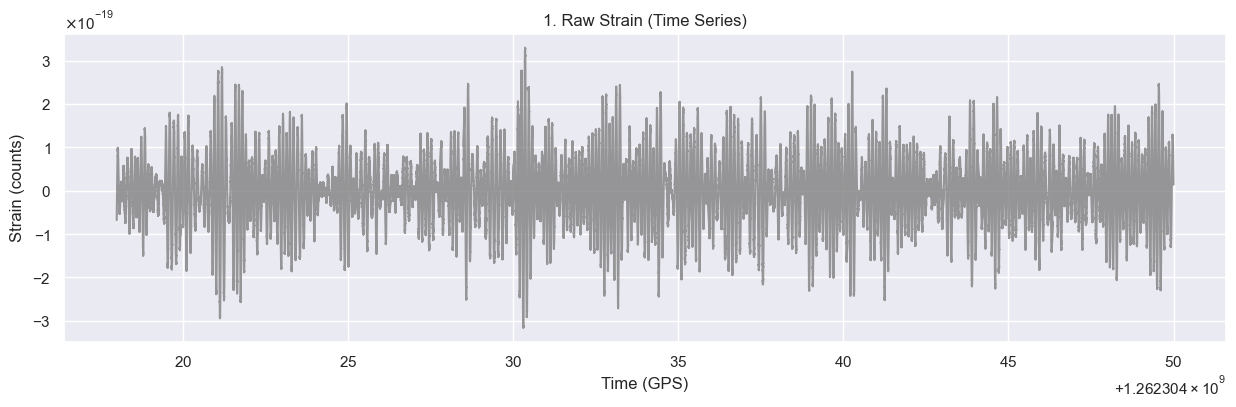

In [3]:
# Parameters
IFO = "H1"
GPS_START = 1262304018  # From our log
DURATION = 32.0
SAMPLE_RATE = 2048.0
F_LOW = 20.0

print(f"Fetching {DURATION}s of data from {IFO} starting at {GPS_START}...")

# 1. Fetch Raw Data
raw_strain = TimeSeries.fetch_open_data(IFO, GPS_START, GPS_START + DURATION, verbose=True, cache=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(raw_strain.times, raw_strain.value, color='gray', alpha=0.8)
ax.set_title("1. Raw Strain (Time Series)")
ax.set_ylabel("Strain (counts)")
ax.set_xlabel("Time (GPS)")
plt.show()

Applying Whitening...


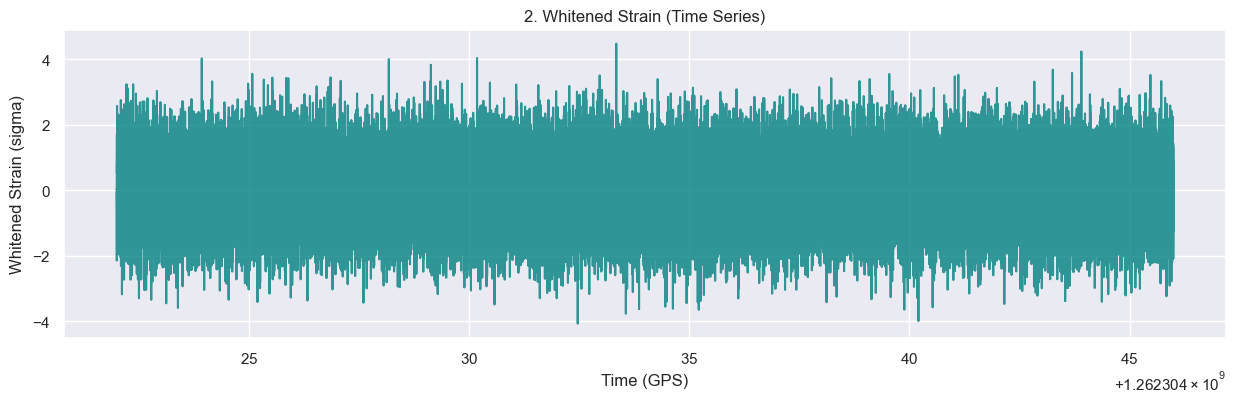

In [4]:
# 2. Whitening & Bandpass
# The get_whitened_strain function handles resampling, highpass, PSD estimation, and whitening.

print("Applying Whitening...")
whitened_strain = get_whitened_strain(raw_strain, SAMPLE_RATE, F_LOW)

# Convert to GWpy for easy plotting
whitened_gwpy = TimeSeries(whitened_strain.numpy(), t0=whitened_strain.start_time, dt=whitened_strain.delta_t)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(whitened_gwpy.times, whitened_gwpy.value, color='teal', alpha=0.8)
ax.set_title("2. Whitened Strain (Time Series)")
ax.set_ylabel("Whitened Strain (sigma)")
ax.set_xlabel("Time (GPS)")
plt.show()

STFT Shape: (191, 257) (Time x Freq)


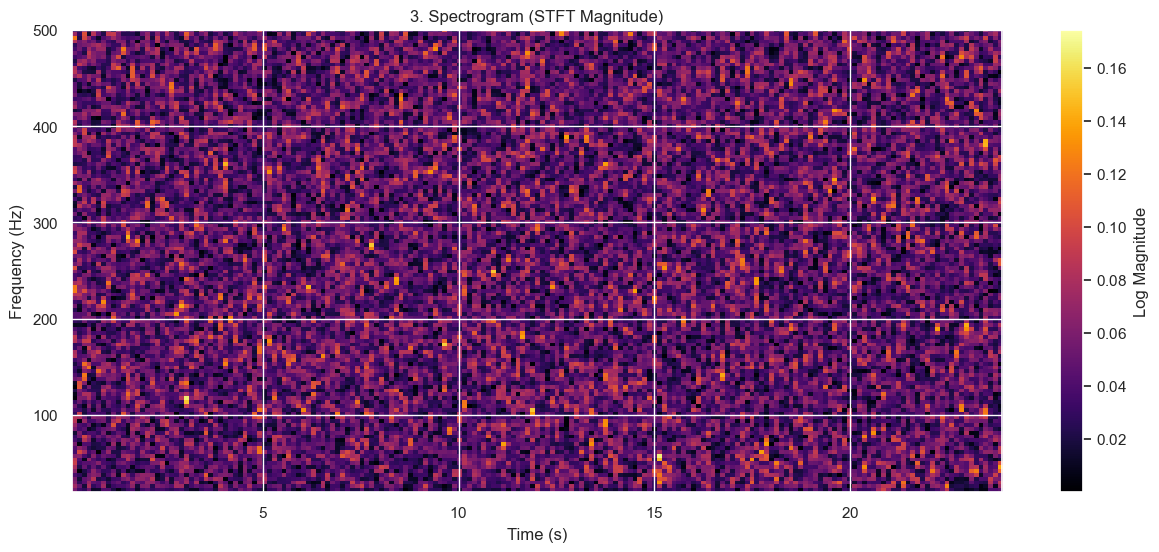

In [5]:
# 3. STFT Computation
# We use the same parameters as the pipeline: 0.25s window, 0.5 overlap

f, t, Zxx = compute_stft(whitened_strain.numpy(), SAMPLE_RATE, window_sec=0.25, overlap_frac=0.5)

print(f"STFT Shape: {Zxx.shape} (Time x Freq)")

# Plot Full Spectrogram
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
im = ax.imshow(np.log1p(np.abs(Zxx.T)), aspect='auto', origin='lower', 
               extent=[t[0], t[-1], f[0], f[-1]], cmap='inferno')
ax.set_title("3. Spectrogram (STFT Magnitude)")
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (s)")
ax.set_ylim(20, 500)  # Zoom in on relevant frequencies
plt.colorbar(im, ax=ax, label="Log Magnitude")
plt.show()

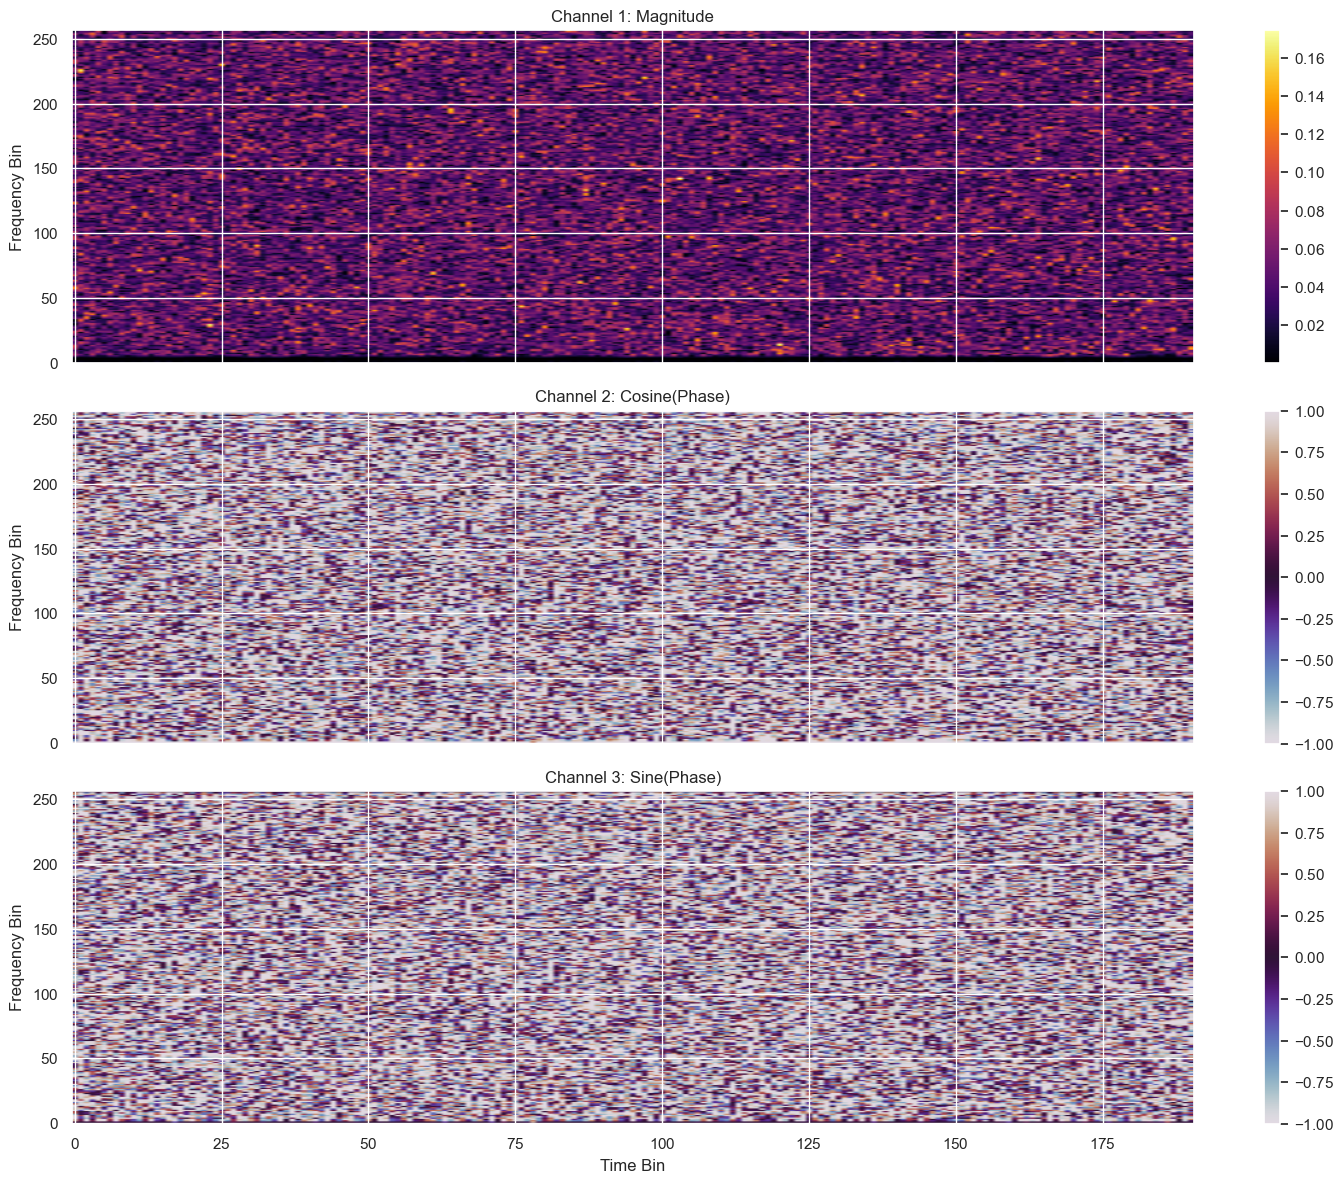

In [6]:
# 4. Feature Decomposition (Mag, Cos, Sin)
# This is the actual input to the CPC-SNN model.

mag, cos, sin = tf_to_mag_phase_channels(Zxx)

fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Magnitude
im0 = axes[0].imshow(np.log1p(mag.T), aspect='auto', origin='lower', cmap='inferno')
axes[0].set_title("Channel 1: Magnitude")
axes[0].set_ylabel("Frequency Bin")
plt.colorbar(im0, ax=axes[0])

# Cosine
im1 = axes[1].imshow(cos.T, aspect='auto', origin='lower', cmap='twilight')
axes[1].set_title("Channel 2: Cosine(Phase)")
axes[1].set_ylabel("Frequency Bin")
plt.colorbar(im1, ax=axes[1])

# Sine
im2 = axes[2].imshow(sin.T, aspect='auto', origin='lower', cmap='twilight')
axes[2].set_title("Channel 3: Sine(Phase)")
axes[2].set_ylabel("Frequency Bin")
axes[2].set_xlabel("Time Bin")
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 3. Injection Visualization

Let's visualize what a pure waveform injection looks like before adding it to noise.

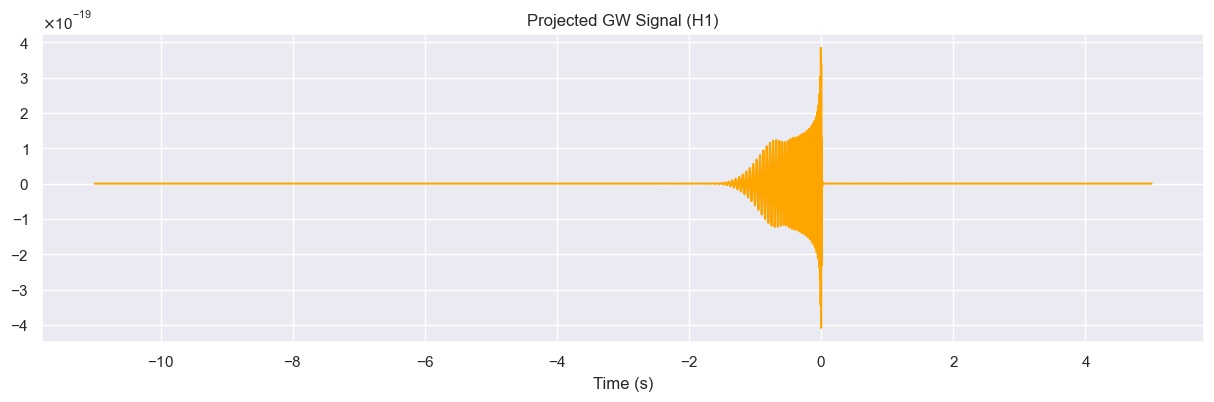

In [7]:
# Generate a dummy waveform
hp, hc = generate_waveform(mass_range=(30, 30), sample_rate=SAMPLE_RATE)

# Project to H1
sig_H1 = project_waveform_to_ifo(hp, hc, "H1", ra=1.0, dec=0.5, psi=0.0, t_gps=GPS_START)

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(sig_H1.sample_times, sig_H1, color='orange')
ax.set_title("Projected GW Signal (H1)")
ax.set_xlabel("Time (s)")
plt.show()